<a href="https://colab.research.google.com/github/RobMcH/gector/blob/master/Demo_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***The cells below have to be executed once to setup everything - This might take a few minutes***

#### Notebook setup

Clone the Github repo:

In [1]:
!git clone https://github.com/RobMcH/gector

Cloning into 'gector'...
remote: Enumerating objects: 417, done.
remote: Counting objects: 100% (337/337), done.
remote: Compressing objects: 100% (214/214), done.
remote: Total 417 (delta 221), reused 212 (delta 117), pack-reused 80
Receiving objects: 100% (417/417), 1.79 MiB | 6.89 MiB/s, done.
Resolving deltas: 100% (252/252), done.


Change the working directory:

In [2]:
%cd /content/gector

/content/gector


Install requirements:

In [3]:
pip install -r requirements.txt

  Cloning https://github.com/amitness/nodebox_linguistics_extended (to revision master) to /tmp/pip-req-build-nwe9a50x
  Running command git clone -q https://github.com/amitness/nodebox_linguistics_extended /tmp/pip-req-build-nwe9a50x
     |████████████████████████████████| 773.1MB 22kB/s 
     |████████████████████████████████| 5.7MB 34.6MB/s 
Reason for being yanked: Insecure, upgrade to 0.12.1
     |████████████████████████████████| 51kB 2.6MB/s 
     |████████████████████████████████| 389kB 49.3MB/s 
     |████████████████████████████████| 5.3MB 17.6MB/s 
     |████████████████████████████████| 1.1MB 38.2MB/s 
     |████████████████████████████████| 3.6MB 32.2MB/s 
     |████████████████████████████████| 122kB 47.6MB/s 
     |████████████████████████████████| 5.6MB 24.1MB/s 
     |████████████████████████████████| 133kB 51.0MB/s 
     |████████████████████████████████| 71kB 10.1MB/s 
     |████████████████████████████████| 266kB 43.5MB/s 
     |████████████████████████████████| 245

In [4]:
!python -m spacy download en_core_web_sm

/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.5) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)
     |████████████████████████████████| 11.1MB 12.1MB/s 
  Created wheel for en-core-web-sm: filename=en_core_web_sm-2.1.0-cp37-none-any.whl size=11074434 sha256=f3e87864f4482b939d187f444f766912a704fb0a93dc386dfb3e6ec2c41c657e
  Stored in directory: /tmp/pip-ephem-wheel-cache-l72hy4y8/wheels/39/ea/3b/507f7df78be8631a7a3d7090962194cf55bc1158572c0be77f
Successfully built en-core-web-sm
  Found existing installation: en-core-web-sm 2.2.5
    Uninstalling en-core-web-sm-2.2.5:
      Successfully uninstalled en-core-web-sm-2.2.5
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


Imports:

In [28]:
from os import path
import matplotlib.pyplot as plt
import numpy as np
import nltk
from IPython.display import SVG, Markdown
from nltk.tokenize.treebank import TreebankWordDetokenizer
import sys
import spacy
from spacy.lang.en import English
from spacy.tokens import Doc, Token, Span
from spacy import displacy
from IPython.core.display import display, HTML
from matplotlib import cm

sys.path.insert(0, '/content/gector/utils')

from adversarial import convert_sentence

%matplotlib inline
plt.style.use('ggplot')
nltk.download('wordnet')

def printmd(string):
    display(Markdown(string))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Load pre-trained models:

In [7]:
# Create new folder for pre-trained models and for the demo files
if path.exists('/content/gector/pre-trained-models') == False:
  os.mkdir('/content/gector/pre-trained-models')

# Load pre-trained Gector BERT model (baseline)
if os.path.isfile('/content/gector/pre-trained-models/bert_0_gector.th') == False:
  !wget -P /content/gector/pre-trained-models https://grammarly-nlp-data-public.s3.amazonaws.com/gector/bert_0_gector.th

# Load our Gector BERT model
if os.path.isfile('/content/gector/pre-trained-models/model_random.th') == False:
  !wget -P /content/gector/pre-trained-models https://gector.s3.eu-west-2.amazonaws.com/model_random.th

--2021-05-31 23:45:29--  https://grammarly-nlp-data-public.s3.amazonaws.com/gector/bert_0_gector.th
Resolving grammarly-nlp-data-public.s3.amazonaws.com (grammarly-nlp-data-public.s3.amazonaws.com)... 52.216.154.172
Connecting to grammarly-nlp-data-public.s3.amazonaws.com (grammarly-nlp-data-public.s3.amazonaws.com)|52.216.154.172|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 448709742 (428M) [application/x-www-form-urlencoded]
Saving to: ‘/content/gector/pre-trained-models/bert_0_gector.th’

bert_0_gector.th    100%[===================>] 427.92M  34.8MB/s    in 14s     

2021-05-31 23:45:44 (31.1 MB/s) - ‘/content/gector/pre-trained-models/bert_0_gector.th’ saved [448709742/448709742]

--2021-05-31 23:45:44--  https://gector.s3.eu-west-2.amazonaws.com/model_random.th
Resolving gector.s3.eu-west-2.amazonaws.com (gector.s3.eu-west-2.amazonaws.com)... 52.95.148.6
Connecting to gector.s3.eu-west-2.amazonaws.com (gector.s3.eu-west-2.amazonaws.com)|52.95.148.6|:4

Instantiate the models:

In [8]:
from gector.gec_model import GecBERTModel

baseline_model = GecBERTModel(vocab_path='data/output_vocabulary',
                             model_paths=["pre-trained-models/bert_0_gector.th"],
                             max_len=50, min_len=3,
                             iterations=5,
                             min_error_probability=0.41,
                             lowercase_tokens=0,
                             model_name='bert',
                             special_tokens_fix=0,
                             log=False,
                             confidence=0.1,
                             is_ensemble=0,
                             weigths=None)

our_model = GecBERTModel(vocab_path='data/output_vocabulary',
                             model_paths=["pre-trained-models/model_random.th"],
                             max_len=50, min_len=3,
                             iterations=5,
                             min_error_probability=0.55,
                             lowercase_tokens=0,
                             model_name='bert',
                             special_tokens_fix=0,
                             log=False,
                             confidence=0.15,
                             is_ensemble=0,
                             weigths=None)

Create a helper-function to visualise the changes:

In [9]:
def visualise_changes(sentence, tags, label=None, color_options=None):
  '''
  Function to create a html which highlights the changes in a sentence

  INPUT:
  sentence        :   (str) sentence
  tags            :   (list) List with tupel (start, end) of each tag
  label           :   [optional] (list) Label for each index (e.g. "ORG")
  color_options   :   [optional] (dict) color setting for each label

  OUTPUT:
  html            :   (html) visualization of tags
  '''
  # Create nlp object (without a NER tagger in the pipeline)
  nlp = English()

  # Tokenize the sentence
  doc = nlp(sentence)

  # Check if custom labels should be used
  if label is None:
    # Default: Create a Span for each match and assign the label "PERTURBED"
    doc.ents = [Span(doc, start, end, label="PERTURBED") for start, end in tags]

    # Define coloring options
    #color_options = {"PERTURBED": "linear-gradient(90deg, #aa9cfc, #fc9ce7)"}
    color_options = {"PERTURBED": "linear-gradient(90deg, rgba(170,156,252,0.5), rgba(252,156,231,0.5))"}
    options = {"ents": ["PERTURBED"], "colors": color_options}

  else:
    # Uppercase all labels
    label = [label_.upper() for label_ in label]

    # Otherwise use custom label
    doc.ents = [Span(doc, start, end, label=label) for (start, end), label in zip(tags, label)]

    # Get unique labels
    unique_labels = list(set(label))

    # Check if custom colors should be used
    if color_options is None:

      # Get the number of unique labels
      n_labels = len(unique_labels)
      
      # Create background colors as rgb
      rgb_vals = (cm.get_cmap('hsv')(np.linspace(0.05,0.6,2*n_labels))*255).astype(int)

      color_options = {}

      # Add colors
      for i, label in enumerate(unique_labels):
        #color_options[label] = "rgba(" + str(rgb_vals[i,0]) + ", " + str(rgb_vals[i,1]) + ", " + str(rgb_vals[i,2]) + ", " + str(0.7) + ")"
        hex1 = '#%02x%02x%02x' % (rgb_vals[2*i,0], rgb_vals[2*i,1], rgb_vals[2*i,2])
        hex2 = '#%02x%02x%02x' % (rgb_vals[2*i+1,0], rgb_vals[2*i+1,1], rgb_vals[2*i+1,2])
        color_options[label] = "linear-gradient(90deg, " + hex1 + ", " + hex2 + ")"
    
    # Create the color options
    options = {"ents": unique_labels, "colors": color_options}

  # Create html and print output
  html = displacy.render(doc, style="ent", options=options)

  # return modified doc
  return html



Get the names of all possible transformations:

In [10]:
with open('/content/gector/data/output_vocabulary/labels.txt') as f:
    gector_label = f.readlines()
    
# remove whitespace characters like `\n` at the end of each line
gector_label = [x.strip() for x in gector_label] 

# **Adversarial Training for Grammatical Error Correction**

*David Byrne, Alan Jeffares, Robert McHardy, Nils Zerrer*

This notebook provides a functional overview of the optimised Gector model as presented in our paper. The notebook consists of two parts:
* The first part is a **personalised demo** where the different parts of the model can be tested using arbitrary examples
* In the second part, specific improvements on pre-defined sentences are **showcased**

## **Personalised demo**

The section below contains a personalised demo. Please feel free to use different sentences and test the model.

Please enter your example sentence below and **[run the cell]**:

In [11]:
user_sentence = "He has ever been with me." #@param {type:"string"} 

perturbations, weights, tokens, indices = convert_sentence(user_sentence, '', our_model)

### Attention weight

One of our main research questions was to analyse, whether sequence tagging models (specifically GECToR) is vulnerable to adversarial attacks (research question 1).
Inspired by *Hsieh et al. (2019)*, we use the attention weight information from the first attention head (visualised below) to determine which token we want to perturb:

<p align="center">
<img src="https://raw.githubusercontent.com/RobMcH/gector/master/figures/attention_weights.svg">
</p>

In our paper we analyse three different approaches:

* Perturb the token with maximum attention weight
* Perturb the token with minimum attention weight
* Perturb a random token

We analysed whether the underlying Transformer architecture allows us to identify tokens that are most vulnerable to adversarial attachs (research question 2).

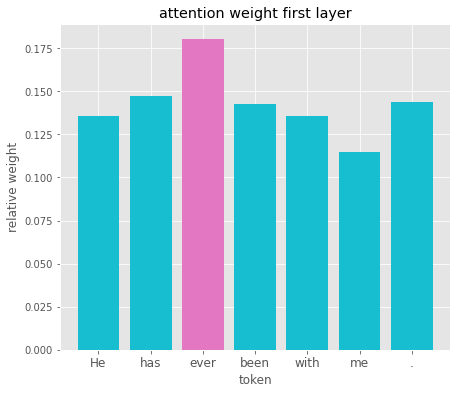

In [12]:
#@markdown **[run the cell]** For your given sentence from before, the attention weight is distributed as follows (the token with the maximum attention weight is highlighted in pink):
weight = weights[0]

x_pos = [i for i, _ in enumerate(tokens)]

max_weight = weight.max()

colors = []
for val in weight:
    if val == max_weight:
        colors.append('tab:pink')
    else:
        colors.append('tab:cyan')

#(0.0, 0.6875, 0.9375)

plt.rcParams['xtick.labelsize']=12

bar_width = max(1, len(max(tokens, key=len))*0.15)

f, ax = plt.subplots(figsize=(bar_width*weight.size,6)) # set the size that you'd like (width, height)
plt.bar(x_pos, weight, color=colors)
plt.xlabel("token")
plt.ylabel("relative weight")
plt.title("relative weight from first attention head")

plt.xticks(x_pos, tokens)


plt.show()

### Perturbation

The previous section introduced three different approaches to identify possible target tokens for the perturbation. After using one of these three methods to determine which token to perturb, we apply a rule-based perturbation. Doing this allows us to genereate a bunch of perturbed sentences as depicted below:

<p align="center">
<img src="https://raw.githubusercontent.com/RobMcH/gector/master/figures/adversarial_sample_generation.svg" width="600"/>
</p>

Note that this is a more sophisticated approach than simple data augmentation since we carry out attention-based token selection and a more specific perturbation. Using the perturbed sentences as additional training data allowed us to analyse whether this technique leads to more robustness and better generalisation performance (research question 3).

As already mentioned, the perturbation is carried out based-on the following rules:

<p align="center">
<img src="https://raw.githubusercontent.com/RobMcH/gector/master/figures/perturbation_rules.svg" width="1000"/>
</p>

For example, if our token is a noun, we exchange the singular and plural form.

In [13]:
#@markdown **[run the cell]** Based on the sentence you defined earlier, we would make the following perturbations (shown for all different token selection methods):

printmd('**Original sentence:**')
html = visualise_changes(user_sentence, [(0,0)])
display(HTML(html))
print('\n')

for i, perturbation in enumerate(perturbations):
  if i == 0:
    change_type = 'Perturbed token with maximum attention weight'
  elif i == 1:
    change_type = 'Perturbed token with minimum attention weight'
  else:
    change_type = 'Perturbed random token'

  if indices[i] == -1:
    html = visualise_changes(perturbation[0], [(0,0)])
    printmd('**' + change_type + ' (removed token):**')
  else:
    html = visualise_changes(perturbation[0], [(indices[i],indices[i]+1)])
    printmd('**' + change_type + ' :**')
  display(HTML(html))

  if i < 2:
    print('\n')

**Original sentence:**

**Perturbed token with maximum attention weight :**

**Perturbed token with minimum attention weight :**

**Perturbed random token :**

### Tagging and Correction

The general structure of the GECToR pipeline is visualised below. At the bottom we can see the tokenised input sentence, which might have one or more grammatical mistakes. Within the pipeline, the tokens are put through a Transformer network (in our case: BERT) which is followed by linear layers. For each input token the model predicts a tag:

* If the model thinks that no adaptions should be made at the given index position (change the token / append sth.) the model predicts the *$KEEP* token
* Otherwise it predicts a specific operation

Finally, the post-processing adapts the input sentence based-on the predicted tags from the transformer network.
Following that, the output of the pipeline can be iteratively fed into the model again. As in the GECToR paper, we stop this process if either:

* The model has made no changes to the input sentence
* The maximum number of 5 iterations is reached

<p align="center">
<img src="https://raw.githubusercontent.com/RobMcH/gector/master/figures/gector_pipeline.svg" width="600"/>
</p>



To get a better understanding for the process, the tagging and correction process is visualised below based-on your own sentence. You can select which model you want to use for the visualisation:
* Ours: Our optimised model for which we achieved the best results (same as the baseline, but trained using the adversarial samples)
* Baseline: The GECToR model based on the BERT transformer network

The predictions are computed in real-time. To make the process even more transparent, we additionally visualised the predicted tags:

In [14]:
#@markdown **[run the cell]**
model = "Ours" #@param ["Ours", "Baseline"]

if model == 'Ours':
  pred_model = our_model
else:
  pred_model = baseline_model

printmd('**Original sentence:**')
html = visualise_changes(user_sentence, [(0,0)])
display(HTML(html))
print('\n')

# Create nlp object
nlp = English()

# Tokenize the sentence
tokens = [token.text for token in nlp(user_sentence)]

# Make prediction
pred_result = pred_model.handle_batch([tokens], True)

# Get number of iterations until correct sentence / max iterations reached
n_iterations = pred_result[1]

# Counter for number of changes
n_changes = 0

# Array of input sentences after each iteration
input_sentences = []

# Create colors
all_labels = []
for i in range(n_iterations):
  all_labels += pred_result[2][i][2][0]

unique_labels = list(set([gector_label[label].upper() for label in all_labels]))

n_labels = len(unique_labels)

# Create background colors as rgb
rgb_vals = (cm.get_cmap('hsv')(np.linspace(0.05,0.6,2*n_labels))*255).astype(int)

color_options = {}

# Add colors
for i, label in enumerate(unique_labels):
  #color_options[label] = "rgba(" + str(rgb_vals[i,0]) + ", " + str(rgb_vals[i,1]) + ", " + str(rgb_vals[i,2]) + ", " + str(0.7) + ")"
  hex1 = '#%02x%02x%02x' % (rgb_vals[2*i,0], rgb_vals[2*i,1], rgb_vals[2*i,2])
  hex2 = '#%02x%02x%02x' % (rgb_vals[2*i+1,0], rgb_vals[2*i+1,1], rgb_vals[2*i+1,2])
  color_options[label] = "linear-gradient(90deg, " + hex1 + ", " + hex2 + ")"

# For each iteration
for i in range(n_iterations):
  input_tokens = pred_result[2][i][0][0]
  
  predicted_tags = pred_result[2][i][2][0]

  input_sentence = ''
  n_tokens = len(input_tokens)

  #for j, token in enumerate(input_tokens):
  #  if j < (n_tokens-1):
  #    input_sentence += token + ' '
  #  else:
  #    input_sentence += token
  input_sentence = TreebankWordDetokenizer().detokenize(input_tokens)
  
  tag_indexes = []
  label = []

  if predicted_tags[0] == 0:
    predicted_tags = predicted_tags[1:]
  else:
    input_sentence = '$ ' + input_sentence

  for k, predicted_tag in enumerate(predicted_tags):
    if not predicted_tag == 0:
      tag_indexes.append((k, k+1))
      label.append(gector_label[predicted_tag])

  #if pred_result[2][i][3][0] > pred_model.min_error_probability:
  printmd('**Iteration ' + str(i+1) + ':**')
  html = visualise_changes(input_sentence, tag_indexes, label, color_options)
  display(HTML(html))
  print('\n')
  #else:
printmd('**Model output:**')
html = visualise_changes(TreebankWordDetokenizer().detokenize(pred_result[0][0]), [(0,0)])
display(HTML(html))

**Original sentence:**

**Iteration 1:**

**Model output:**

## **Showcase**

In the following, we present the specific improvements for pre-defined sentences.
As described in the paper, our model was able to:
* Outperform the baseline model (based on BERT)
* Develop some degree of roubstness against our adversarial attacks

For those different scenarios, we prepared some example sentences below where those improvements become apparent.

### General performance increase

As presented in the paper, we were able to achieve a significant performance increase using the rule-based perturbations. In particular, all models trained with the adversarially generated samples (no matter if wa made one or two perturbations), outperformed the baseline on the BEA-2019 test set (which is the state of the art dataset for grammatical error correction). The resulting $F_{0.5}$ scores for the different perturbation methods are shown in the bar chart below. Those results are more closely analysed in our paper.

<p align="center">
<img src="https://raw.githubusercontent.com/RobMcH/gector/master/figures/overall_results.svg" width="1000"/>
</p>

We selected a few sentences from the BEA-2019 development set, which give a better intuition for the specific improvements:

In [33]:
#@markdown **[run the cell]** The model (choose either ours or the basline) makes the following iterative corrections:
model = "Ours" #@param ["Ours", "Baseline"]
sentence = "It is dynamic, stimulating and, even if it is not well remunerated, I feel myself satisfied." #@param ["It is dynamic, stimulating and, even if it is not well remunerated, I feel myself satisfied.", "He has ever been with me.", "He started to think about how he could get better our lives and he found a solution.", "Michael closed the door and knew at the moment he made a mistake."]

if model == 'Ours':
  pred_model = our_model
else:
  pred_model = baseline_model

printmd('**Original sentence:**')
html = visualise_changes(sentence, [(0,0)])
display(HTML(html))
print('\n')

# Create nlp object
nlp = English()

# Tokenize the sentence
tokens_predef = [token.text for token in nlp(sentence)]

# Make prediction
pred_result = pred_model.handle_batch([tokens_predef], True)

# Get number of iterations until correct sentence / max iterations reached
n_iterations = pred_result[1]

# Counter for number of changes
n_changes = 0

# Array of input sentences after each iteration
input_sentences = []

# Create colors
all_labels = []
for i in range(n_iterations):
  all_labels += pred_result[2][i][2][0]

unique_labels = list(set([gector_label[label].upper() for label in all_labels]))

n_labels = len(unique_labels)

# Create background colors as rgb
rgb_vals = (cm.get_cmap('hsv')(np.linspace(0.05,0.6,2*n_labels))*255).astype(int)

color_options = {}

# Add colors
for i, label in enumerate(unique_labels):
  #color_options[label] = "rgba(" + str(rgb_vals[i,0]) + ", " + str(rgb_vals[i,1]) + ", " + str(rgb_vals[i,2]) + ", " + str(0.7) + ")"
  hex1 = '#%02x%02x%02x' % (rgb_vals[2*i,0], rgb_vals[2*i,1], rgb_vals[2*i,2])
  hex2 = '#%02x%02x%02x' % (rgb_vals[2*i+1,0], rgb_vals[2*i+1,1], rgb_vals[2*i+1,2])
  color_options[label] = "linear-gradient(90deg, " + hex1 + ", " + hex2 + ")"

# For each iteration
for i in range(n_iterations):
  input_tokens = pred_result[2][i][0][0]
  
  predicted_tags = pred_result[2][i][2][0]

  input_sentence = ''
  n_tokens = len(input_tokens)

  #for j, token in enumerate(input_tokens):
  #  if j < (n_tokens-1):
  #    input_sentence += token + ' '
  #  else:
  #    input_sentence += token
  input_sentence = TreebankWordDetokenizer().detokenize(input_tokens)
  
  tag_indexes = []
  label = []

  if predicted_tags[0] == 0:
    predicted_tags = predicted_tags[1:]
  else:
    input_sentence = '$ ' + input_sentence

  for k, predicted_tag in enumerate(predicted_tags):
    if not predicted_tag == 0:
      tag_indexes.append((k, k+1))
      label.append(gector_label[predicted_tag])

  #if pred_result[2][i][3][0] > pred_model.min_error_probability:
  printmd('**Iteration ' + str(i+1) + ':**')
  html = visualise_changes(input_sentence, tag_indexes, label, color_options)
  display(HTML(html))
  print('\n')
  #else:
printmd('**Model output:**')
html = visualise_changes(TreebankWordDetokenizer().detokenize(pred_result[0][0]), [(0,0)])
display(HTML(html))

**Original sentence:**

**Iteration 1:**

**Model output:**

### Increased robustness

Additionally we carried out experiments to compare whether out approach increases the robustness of the model. 
For this, we optimised the baseline model based on three different datasets:
* A dataset where we perturbed a randomly selected token
* A dataset where we perturbed the token with minimum attention weight in the first attention head
* A dataset where we perturbed the token with maximum attention weight in the first attention head

After that we attacked those three models (and the baseline) with new sentences.
For those new sentences, we carried out the following attacks:
* Perturb a random token
* Perturb the token with minimum attention weight in the first attention head
* Perturb the token with maximum attention weight in the first attention head

As can be seen in the bar chart below: In each case, the model which was trained on the data that already included the same kind of attacks, turned out to be superior.
Additionally, note that the robustness against all attacks increased in all experiments (compared to the baseline).

<p align="center">
<img src="https://raw.githubusercontent.com/RobMcH/gector/master/figures/robustness_results.svg" width="1000"/>
</p>

As before, we selected some examples from the BEA-2019 development set. In the selected cases, the baseline model predicts that the perturbed sentences are still correct, which clearly is not the case. However, as already demonstrated in our experiments, our optimised model has developped some degree of robustness against those attacks.

In [26]:
#@markdown **[run the cell]** The model (choose either ours or the basline) makes the following iterative corrections:
model = "Ours" #@param ["Ours", "Baseline"]
sentence = "good mornings." #@param ["good mornings.", "The city where mine live is a small village.", "I went with my parents my sister.", "There is no point in saying publically transport has no future."]

if model == 'Ours':
  pred_model = our_model
else:
  pred_model = baseline_model


if sentence == "good mornings.":
  printmd('**Pertubed sentence:**')
  html = visualise_changes(sentence, [(1,2)])
elif sentence == "The city where mine live is a small village.":
  printmd('**Pertubed sentence:**')
  html = visualise_changes(sentence, [(3,4)])
elif sentence == "I went with my parents my sister.":
  printmd('**Pertubed sentence (removed *and*-token):**')
  html = visualise_changes(sentence, [(0,0)])
else:
  printmd('**Pertubed sentence:**')
  html = visualise_changes(sentence, [(6,7)])

display(HTML(html))
print('\n')

# Create nlp object
nlp = English()

# Tokenize the random perturberd sentence
tokens_predef = [token.text for token in nlp(sentence)]

# Make prediction
pred_result = pred_model.handle_batch([tokens_predef], True)

# Get number of iterations until correct sentence / max iterations reached
n_iterations = pred_result[1]

# Counter for number of changes
n_changes = 0

# Array of input sentences after each iteration
input_sentences = []

# Create colors
all_labels = []
for i in range(n_iterations):
  all_labels += pred_result[2][i][2][0]

unique_labels = list(set([gector_label[label].upper() for label in all_labels]))

n_labels = len(unique_labels)

# Create background colors as rgb
rgb_vals = (cm.get_cmap('hsv')(np.linspace(0.05,0.6,2*n_labels))*255).astype(int)

color_options = {}

# Add colors
for i, label in enumerate(unique_labels):
  #color_options[label] = "rgba(" + str(rgb_vals[i,0]) + ", " + str(rgb_vals[i,1]) + ", " + str(rgb_vals[i,2]) + ", " + str(0.7) + ")"
  hex1 = '#%02x%02x%02x' % (rgb_vals[2*i,0], rgb_vals[2*i,1], rgb_vals[2*i,2])
  hex2 = '#%02x%02x%02x' % (rgb_vals[2*i+1,0], rgb_vals[2*i+1,1], rgb_vals[2*i+1,2])
  color_options[label] = "linear-gradient(90deg, " + hex1 + ", " + hex2 + ")"

# For each iteration
for i in range(n_iterations):
  input_tokens = pred_result[2][i][0][0]
  
  predicted_tags = pred_result[2][i][2][0]

  input_sentence = ''
  n_tokens = len(input_tokens)

  #for j, token in enumerate(input_tokens):
  #  if j < (n_tokens-1):
  #    input_sentence += token + ' '
  #  else:
  #    input_sentence += token
  input_sentence = TreebankWordDetokenizer().detokenize(input_tokens)
  
  tag_indexes = []
  label = []

  if predicted_tags[0] == 0:
    predicted_tags = predicted_tags[1:]
  else:
    input_sentence = '$ ' + input_sentence

  for k, predicted_tag in enumerate(predicted_tags):
    if not predicted_tag == 0:
      tag_indexes.append((k, k+1))
      label.append(gector_label[predicted_tag])


  #if pred_result[2][i][3][0] > pred_model.min_error_probability:
  printmd('**Iteration ' + str(i+1) + ':**')
  html = visualise_changes(input_sentence, tag_indexes, label, color_options)
  display(HTML(html))
  print('\n')
  #else:
printmd('**Model output:**')
html = visualise_changes(TreebankWordDetokenizer().detokenize(pred_result[0][0]), [(0,0)])
display(HTML(html))

**Pertubed sentence:**

**Model output:**